Optimal number of clusters based on DB Index: 2


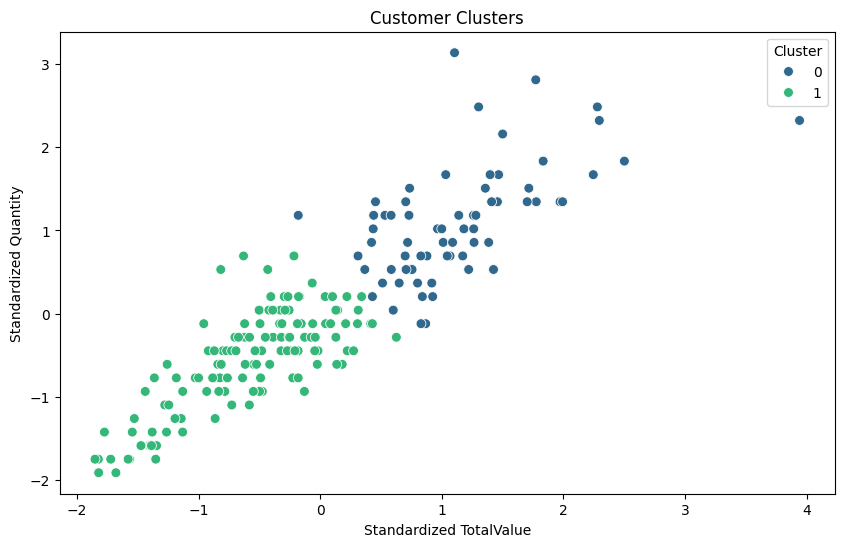

Final DB Index: 0.9141


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate transaction data for customer-level features
customer_transaction_data = transactions.groupby("CustomerID").agg({
    "TotalValue": "sum",      # Total spending
    "Quantity": "sum"         # Total quantity purchased
}).reset_index()

# Merge customer profiles with aggregated transaction data
customer_data = pd.merge(customers, customer_transaction_data, on="CustomerID", how="inner")

# Encode categorical features (e.g., Region)
customer_data_encoded = pd.get_dummies(customer_data, columns=["Region"], drop_first=True)

# Standardize the numerical features
numerical_features = ["TotalValue", "Quantity"]
scaler = StandardScaler()
customer_data_encoded[numerical_features] = scaler.fit_transform(customer_data_encoded[numerical_features])

# Drop non-numeric columns before clustering
features_to_cluster = customer_data_encoded.drop(["CustomerID", "Name"], axis=1, errors="ignore")

# Choose the range for number of clusters (2 to 10)
db_indices = []
k_values = range(2, 11)

# Drop non-numeric columns before clustering
# Include 'CustomerName' and 'SignupDate' columns in the drop list
features_to_cluster = customer_data_encoded.drop(["CustomerID", "Name", "CustomerName", "SignupDate"], axis=1, errors="ignore")

for k in k_values:
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(features_to_cluster)

    # Calculate the DB Index
    db_index = davies_bouldin_score(features_to_cluster, cluster_labels)
    db_indices.append(db_index)

# Find the optimal number of clusters based on DB Index (lower is better)
optimal_k = k_values[db_indices.index(min(db_indices))]
print(f"Optimal number of clusters based on DB Index: {optimal_k}")

# Perform clustering with the optimal number of clusters
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data_encoded["Cluster"] = final_kmeans.fit_predict(features_to_cluster)

# Visualization of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=features_to_cluster["TotalValue"],
    y=features_to_cluster["Quantity"],
    hue=customer_data_encoded["Cluster"],
    palette="viridis",
    s=50
)
plt.title("Customer Clusters")
plt.xlabel("Standardized TotalValue")
plt.ylabel("Standardized Quantity")
plt.legend(title="Cluster")
plt.show()

# Report DB Index value and other metrics
print(f"Final DB Index: {min(db_indices):.4f}")